In [9]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
   tf.config.experimental.set_memory_growth(gpus[0], True)

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from keras import Input
from keras.layers import Conv2D, Dropout, MaxPooling2D, UpSampling2D
from pathlib import Path
import utility as utils
from keras_segmentation.models.model_utils import get_segmentation_model, concatenate
from keras_segmentation.models.pspnet import pspnet


data_dir = Path('dataset/')
sun_dir = Path('sunrgb/')

rgb_dir = sun_dir / "rgb"
seg_dir = sun_dir / "seg"

train_img_dir = data_dir / "train" / 'rgb'
train_seg_dir = data_dir / "train" / 'seg'

val_img_dir = data_dir / "val" / 'rgb'
val_seg_dir = data_dir / "val" / 'seg'

test_img_dir = data_dir / "test" / 'rgb'
test_seg_dir = data_dir / "test" / 'seg'

check_dir = data_dir / "checkpoints" / "pspnet"

print(tf.version.VERSION)

photo_size = (576, 768, 3)
number_classes = 38
# net = tf.keras.applications.densenet.DenseNet201(include_top=False, weights='imagenet', input_shape=photo_size, classes=number_classes)

2.1.0


In [2]:
#utils.split_train_val(0.8, rgb_dir, seg_dir, train_img_dir, train_seg_dir, val_img_dir, val_seg_dir)

In [13]:
img_input = Input(shape=(photo_size[0],photo_size[1] , photo_size[2] ))

conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
conv1 = Dropout(0.2)(conv1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Dropout(0.2)(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)

In [14]:
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Dropout(0.2)(conv3)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

In [15]:
up1 = concatenate([UpSampling2D((2, 2))(conv3), conv2], axis=-1)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
conv4 = Dropout(0.2)(conv4)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)

up2 = concatenate([UpSampling2D((2, 2))(conv4), conv1], axis=-1)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
conv5 = Dropout(0.2)(conv5)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)


In [ ]:
out = Conv2D( number_classes, (1, 1) , padding='same')(conv5)

model = get_segmentation_model(img_input , out)

In [10]:

base_model = pspnet(number_classes, input_height=photo_size[0], input_width=photo_size[1])

base_model.summary()

base_model.train(
    train_images=str(train_img_dir.resolve()),
    train_annotations=str(train_seg_dir.resolve()),
    checkpoints_path=str(check_dir.resolve()),
    epochs=5)

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 576, 768, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_21 (ZeroPadding2 (None, 578, 770, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 576, 768, 64) 1792        zero_padding2d_21[0][0]          
__________________________________________________________________________________________________
batch_normalization_41 (BatchNo (None, 576, 768, 64) 256         conv2d_45[0][0]                  
___________________________________________________________________________________________

100%|██████████| 7234/7234 [00:33<00:00, 213.22it/s]


In [21]:
d = {0:'None',
    1:'wall',
2:'floor',
3:'cabinet',
4:'bed',
5:'chair',
6:'sofa',
7:'table',
8:'door',
9:'window',
10:'bookshelf',
11:'picture',
12:'counter',
13:'blinds',
14:'desk',
15:'shelves',
16:'curtain',
17:'dresser',
18:'pillow',
19:'mirror',
20:'floor_mat',
21:'clothes',
22:'ceiling',
23:'books',
24:'fridge',
25:'tv',
26:'paper',
27:'towel',
28:'shower_curtain',
29:'box',
30:'whiteboard',
31:'person',
32:'night_stand',
33:'toilet',
34:'sink',
35:'lamp',
36:'bathtub',
37:'bag'
}

l = [(k,v) for (k,v) in d.items()]

immagine di input =  img_04178
loaded weights  D:\Gitkraken\IPCV\dataset\checkpoints\pspnet.4


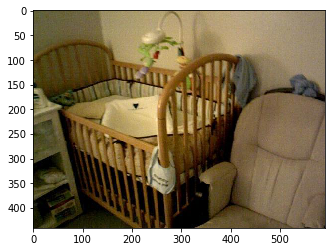

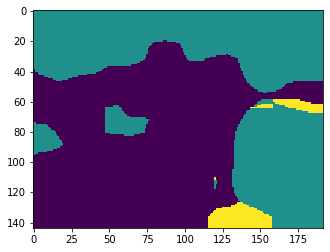

In [23]:
from keras_segmentation.predict import predict
import random
import os

os.makedirs(data_dir / 'output', exist_ok=True)
out_dir = data_dir / "output" / "output.png"
input_image = random.choice(list(val_img_dir.glob('*')))
print('immagine di input = ', input_image.stem)


prediction = predict(
	checkpoints_path=str(check_dir.resolve()),
	inp=str(input_image.resolve()),
	out_fname=str(out_dir.resolve()),
    # show_legends=True, class_names=l
)

original = plt.imread(str(input_image.resolve()))
plt.figure()
plt.imshow(original)
plt.figure()
plt.imshow(prediction)